# What other models are there?
## Is it a behs?

I'm adding some constants up top so I can experiment / tune things quickly

In [1]:
IMAGES_PER_SEARCH = 800

MODEL_ARCH = "resnext101_32x8d"

from pprint import pprint
# What other models are there?
# import timm
# see eg https://docs.fast.ai/vision.learner.html#vision_learner
# `If you pass a str to arch, then a timm model will be created`
#model_names = timm.list_models('*resne*t*')
#pprint(model_names)

print(f"Playing with image model arch {MODEL_ARCH}, picked a pretrained image classifier from https://huggingface.co/docs/timm/models")


Playing with image model arch resnext101_32x8d, picked a pretrained image classifier from https://huggingface.co/docs/timm/models


In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
    print("Network OK")
except socket.error as ex:
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Network OK


In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'
    !pip freeze | grep fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.3 MB/s eta 0:00:00
fastai==2.7.18


In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

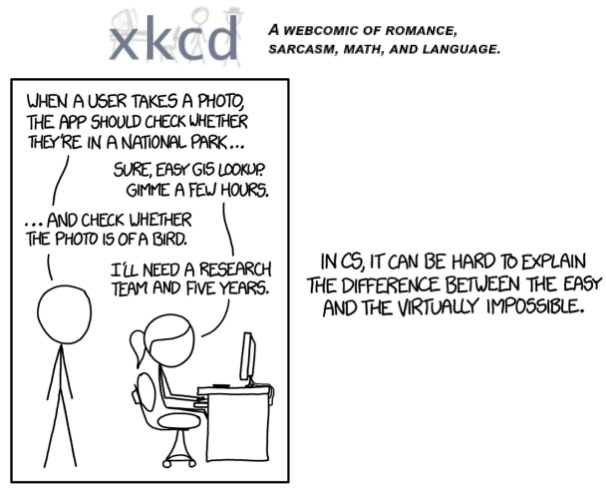

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of things (basses, guitars, puppies, kittens)

In [4]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
import time, json

L?

def search_images(keywords, max_images=IMAGES_PER_SEARCH): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).

BASS_SEARCH = 'electric "bass guitar" photo -upright -acoustic'
urls = search_images(BASS_SEARCH, max_images=1)
urls[0]

'https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/8_Full_Left_Front_NA-81b024b18761ca230752227a2999cfb7.jpg'

...and then download a URL and take a look at it:

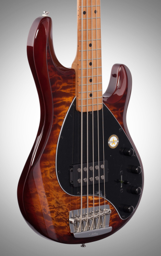

In [6]:
from fastdownload import download_url
from fastai.vision.all import *

Image?

dest = 'bass.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with our second category:

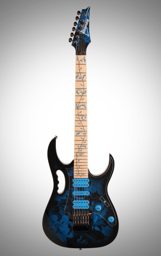

In [7]:
GUITAR_SEARCH = '"electric guitar" photo -bass'
download_url(search_images(GUITAR_SEARCH, max_images=1)[0], 'guitar.jpg', show_progress=False)
Image.open('guitar.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bass" and "guitar" photos, and save each group of photos to a different folder:

In [8]:
searches = (
    (BASS_SEARCH, 'bass'),
    (GUITAR_SEARCH, 'guitar'),
    ('adorable fuzzy "kitten" -puppy', 'kitten'),
    ('cute "puppy" -kitten', 'puppy'),
)

!rm -rf bass_or_not

path = Path('bass_or_not')

# download_images?

for search, o in searches:
    dest = (path/o)
    print(f"Saving to {dest}")
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(search))
    print("Downloaded, now syncing and resizing...")
    !sync
    time.sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)
print("ok")

Saving to bass_or_not/bass
Downloaded, now syncing and resizing...
Saving to bass_or_not/guitar
Downloaded, now syncing and resizing...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Saving to bass_or_not/kitten
Downloaded, now syncing and resizing...
Saving to bass_or_not/puppy
Downloaded, now syncing and resizing...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


ok


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Failed images: {len(failed)}")

!echo Images kept:
!find bass_or_not/ -type f | wc -l

Failed images: 52
Images kept:
1321


To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

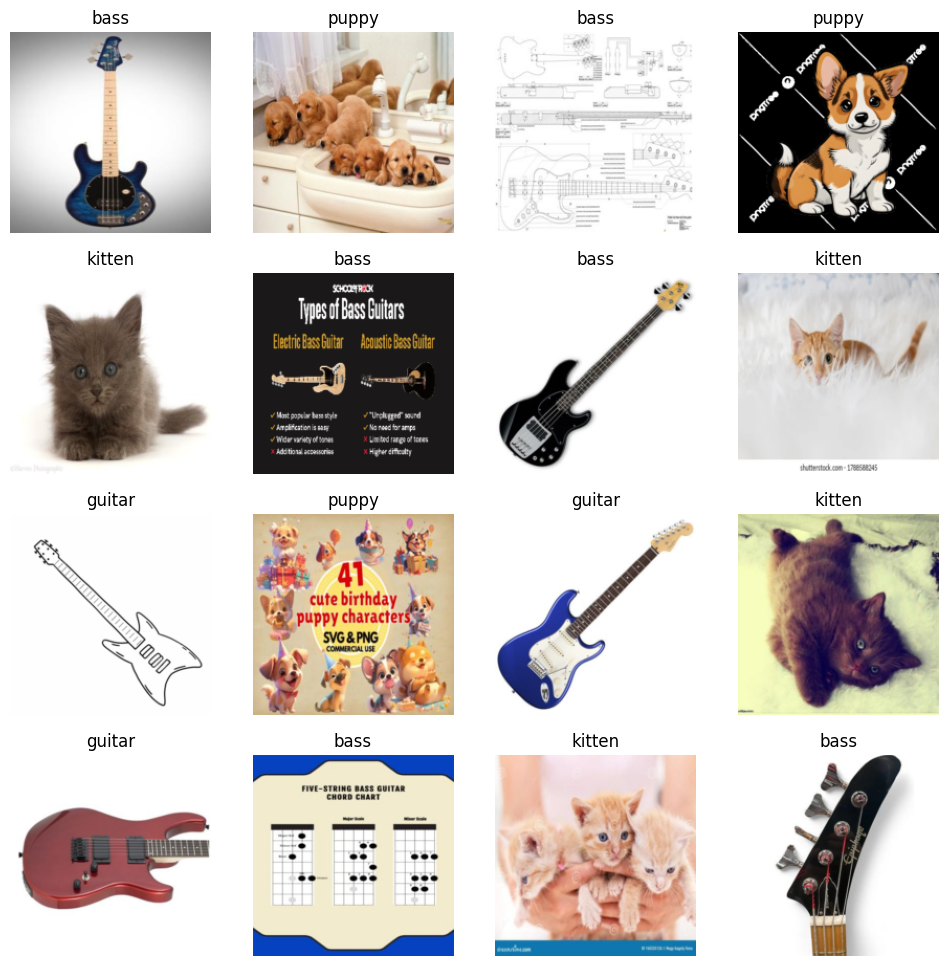

In [10]:
?DataBlock

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=45),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

?dls.show_batch
dls.show_batch(max_n=16)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
?vision_learner
learn = vision_learner(dls, MODEL_ARCH, metrics=error_rate)

# ?learn.fine_tune
learn.fine_tune(4) # Why does he do 3, and why isn't more better?

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.125322,1.046930,0.207843,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.535785,0.663704,0.200000,00:21
1,0.392090,0.815049,0.200000,00:21
2,0.263805,0.831461,0.184314,00:21
3,0.162144,0.770221,0.180392,00:21


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [12]:
is_bass,_,probs = learn.predict(PILImage.create('bass.jpg'))
print(f"This is a: {is_bass}.")
print(f"Probability it's a bass: {probs[0]:.4f}")

This is a: bass.
Probability it's a bass: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

In [13]:
# What is the API of learn.predict?
?learn.predict

Images that should be valid bass, guitar, puppy, or kitten!



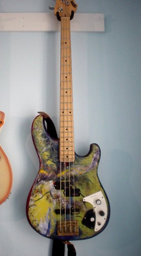

This is a: bass. Probabilities: 0.9423, 0.0549, 0.0028, 0.0000
________________________________________



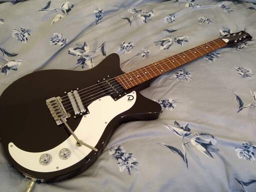

This is a: guitar. Probabilities: 0.4104, 0.5893, 0.0003, 0.0000
________________________________________



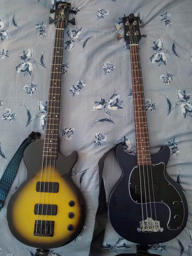

This is a: bass. Probabilities: 0.9943, 0.0053, 0.0004, 0.0000
________________________________________



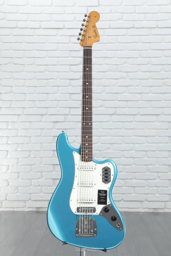

This is a: guitar. Probabilities: 0.0177, 0.9785, 0.0032, 0.0006
________________________________________



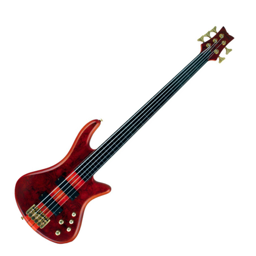

This is a: bass. Probabilities: 0.9006, 0.0913, 0.0076, 0.0005
________________________________________



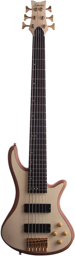

This is a: bass. Probabilities: 0.5450, 0.4538, 0.0009, 0.0003
________________________________________



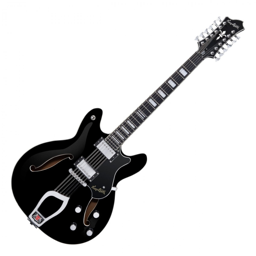

This is a: guitar. Probabilities: 0.0149, 0.9843, 0.0003, 0.0005
________________________________________



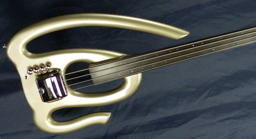

This is a: guitar. Probabilities: 0.0785, 0.8946, 0.0013, 0.0256
________________________________________



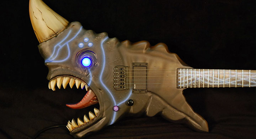

This is a: guitar. Probabilities: 0.0000, 0.9998, 0.0001, 0.0001
________________________________________



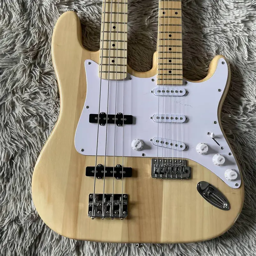

This is a: bass. Probabilities: 0.8691, 0.0330, 0.0979, 0.0000
________________________________________



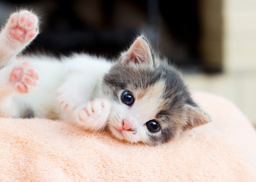

This is a: kitten. Probabilities: 0.0000, 0.0000, 1.0000, 0.0000
________________________________________



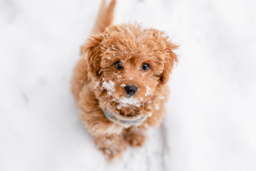

This is a: puppy. Probabilities: 0.0000, 0.0000, 0.0000, 1.0000
________________________________________



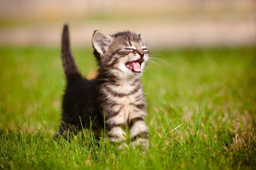

This is a: kitten. Probabilities: 0.0000, 0.0000, 1.0000, 0.0000
________________________________________

Images of other things!



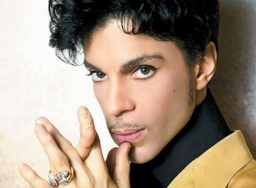

This is a: kitten. Probabilities: 0.2908, 0.0077, 0.6120, 0.0896
________________________________________



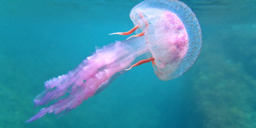

This is a: puppy. Probabilities: 0.0657, 0.1334, 0.0117, 0.7892
________________________________________



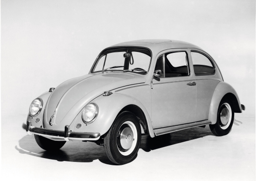

This is a: puppy. Probabilities: 0.0078, 0.4840, 0.0049, 0.5033
________________________________________



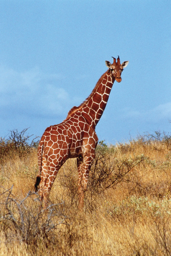

This is a: puppy. Probabilities: 0.0069, 0.0040, 0.0452, 0.9440
________________________________________



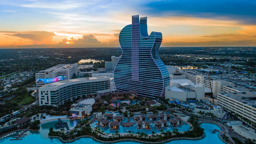

This is a: guitar. Probabilities: 0.0000, 0.9960, 0.0040, 0.0001
________________________________________



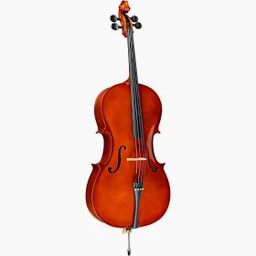

This is a: bass. Probabilities: 0.9741, 0.0010, 0.0003, 0.0247
________________________________________



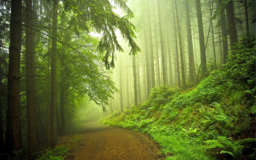

This is a: puppy. Probabilities: 0.0014, 0.4082, 0.1657, 0.4247
________________________________________


In [14]:
from IPython.display import display
import os

urls = [("https://slinkp.com/bass/gear/ibanez_blazer", "blazer.jpg"),
        ("https://slinkp.com/bass/gear/danelectro_59xt_IMG_20210927_165223546", "xt.jpg"),
        ("https://slinkp.com/bass/gear/lpb_dc_tribute_IMG_20210729_114609522", "two_basses.jpg"),
        ("https://media.sweetwater.com/m/products/image/be1d9fce322dLyICPyTowo0CckhhVwT5gXyJYjOQ.wm-lh.jpg?quality=82&height=750&ws=s&ha=be1d9fce32488bb4", "fender_bass_VI.jpg"),
        ("http://2.bp.blogspot.com/-OVj2ExXhj7U/TVkhNAzKBzI/AAAAAAAACHw/rnFWmj2jwKc/s1600/s-ss5.jpg", "5_string.jpg"),
        ("https://m.media-amazon.com/images/I/517H+wLqL-L._AC_SL1500_.jpg", "6_string_bass.jpg"),
        # ("https://preview.redd.it/i-need-help-identifying-this-guitar-v0-99kymgj6wbjc1.jpg?width=3024&format=pjpg&auto=webp&s=dda3180a255ea3b19173a4d84744393f058417fb", 'old_silvertone_guitar.jpg'),
        # ("https://i.redd.it/0tn9aekkxm8c1.jpeg", 'japanese_viol_bass.jpg'),
        # ("https://preview.redd.it/octopus-guitar-v0-y6oxd1i93z4c1.jpg?width=3024&format=pjpg&auto=webp&s=765439ef7d096ccba8fdd186d59de29b2c4a2ef5", 'octo_guitar.jpg'),
        ("https://r2.gear4music.com/media/93/936012/1200/preview.jpg?_gl=1*15y43wq*_up*MQ..*_ga*MTUyNDg4NDA2OS4xNzM5MzgyODQ0*_ga_2H8HL0FNRM*MTczOTM4Mjg0My4xLjAuMTczOTM4Mjg0My4wLjAuMA..", 
         'hagstrom_12_guitar.jpg'),
        ("https://res.cloudinary.com/reverb-cms/image/upload/backfilled/curation/kopo-bass_sfit9r.jpg", 
         "weird_reverb_bass.jpg"),
        ("https://res.cloudinary.com/reverb-cms/image/upload/backfilled/curation/kaiju-guitar_iifkvj.jpg", 
         "kaiju_gtr.jpg"),
        ("https://img.kwcdn.com/product/open/522f27e67f0143969f7ee65b5a049bcd-goods.jpeg?imageView2/2/w/800/q/70/format/webp", 
         "guitar_bass_doubleneck.jpg"),
        ("https://t3.ftcdn.net/jpg/02/08/82/78/360_F_208827851_Wl7QZ34VRdzfR7n00GUKSaQHUK19TAzq.jpg", 
         "kitten.jpg"),
        ("https://www.thesprucepets.com/thmb/YBO6dLNaRUrr34ra0W4KGim00q4=/6411x0/filters:no_upscale():strip_icc()/puppies-three-to-six-months-4570930-hero-bf2f59d75dcb4294991d6bd8cd51ec7c.jpg", 
         "puppy.jpg"),
        ("https://smb.ibsrv.net/imageresizer/image/article_manager/1200x1200/20586/516506/heroimage0.327162001643150501.jpg", 
         "another_kitten.jpg")
       ]

bogus_urls = [
    ("https://www.mnopedia.org/sites/default/files/styles/xlarge/public/prince_2000_2005.jpg?itok=PSdZUsQD", 
     "prince.jpg"),
    ("https://scopeblog.stanford.edu/wp-content/uploads/2023/06/AdobeStock_35446955-1152x578.jpeg",
    "jellyfish.jpg"),
    ("https://uploads.vw-mms.de/system/production/images/vwn/012/208/images/e413288922c14ecd78864424aa5f12ed969da62b/DB2007AU00446_web_1600.jpg?1649148574",
    "volkswagen.jpg"),
    ("https://cdn.britannica.com/55/75855-050-3D52AB80/giraffe-Kenya.jpg",
    "giraffe.jpg"),
    ("https://www.archpaper.com/wp-content/uploads/2019/11/Guitar-6.jpg",
    "hard_rock_hotel.jpg"),
    ("https://encrypted-tbn2.gstatic.com/shopping?q=tbn:ANd9GcS2KbyK92QLQ1A-_Yvw7EQ5XWCOWW6BD-NAvm5ltLt25k8EXgQD1nB6QhIVS-qa3zvMF5x-iTOA5S9HVmkOGMlEsqosaEaKY8jyLTS0WedeaQheJNdFTqP1QXxzvDuI&usqp=CAc",
    "chello.jpg"),
    ("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallpaperbat.com%2Fimg%2F588760-most-beautiful-forest-wallpaper-beautiful-forest-forest-wallpaper-conifer-forest.jpg&f=1&nofb=1&ipt=65339639510241edc5c9c78df17c6c1457558e3914cd3901ba580a3d0fa83545&ipo=images",
    "forest.jpg"),    
]

def categorize_image(url, dest):
    print(f"\nDownloading {url} to {dest}...")
    try:
        download_url(url, dest, show_progress=False)
    except Exception as e:
        print(f"Download error {type(e)}, skipping...")
        return
    os.system("sync")
    if not verify_image(dest):
        print(f"Bad image {dest}, skipping")
        return
    im = Image.open(dest)
    display(im.to_thumb(256,256))
    is_bass, _, probs = learn.predict(im)
    probs = ", ".join([f"{prob:.4f}" for prob in probs])
    print(f"This is a: {is_bass}. Probabilities: {probs}")
    print("_" * 40)

print("Images that should be valid bass, guitar, puppy, or kitten!")
for url, dest in urls:
    categorize_image(url, dest)
    
print()
print("=" * 70)
print("Images of other things!")
for url, dest in bogus_urls:
    categorize_image(url, dest)